In [125]:
import pandas as pd
import numpy as np
import os
import glob
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     Activation, Flatten, Conv2D,GlobalAveragePooling2D,
                                     MaxPooling2D)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [91]:
# IMDE image 人臉資料集來源: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/


# x = os.getcwd()
# print(x)
os.chdir('/Users/macy1/JupyterLab/project1')

In [92]:
# gender: 0: 女, 1: 男
wiki = pd.read_csv('wiki_info.csv')
wiki

,year,photo_takens,path,gender
0,1982,2009,17/10000217_1981-05-05_2009.jpg,1.0
1,1926,1964,48/10000548_1925-04-04_1964.jpg,1.0
2,1949,2008,12/100012_1948-07-03_2008.jpg,1.0
3,1972,2012,16/10002116_1971-05-31_2012.jpg,0.0
4,1962,2012,02/10002702_1960-11-09_2012.jpg,0.0
...,...,...,...,...
44286,1959,2006,23/8996023_1957-09-26_2006.jpg,1.0
44287,1932,1961,19/899619_1930-12-31_1961.jpg,0.0
44288,1933,2012,26/899626_1932-08-31_2012.jpg,1.0
44289,1901,1947,66/899666_1900-06-03_1947.jpg,1.0


In [93]:
#加入年齡欄位['age']

wiki['age'] = wiki['photo_takens'] - wiki['year']
wiki

,year,photo_takens,path,gender,age
0,1982,2009,17/10000217_1981-05-05_2009.jpg,1.0,27
1,1926,1964,48/10000548_1925-04-04_1964.jpg,1.0,38
2,1949,2008,12/100012_1948-07-03_2008.jpg,1.0,59
3,1972,2012,16/10002116_1971-05-31_2012.jpg,0.0,40
4,1962,2012,02/10002702_1960-11-09_2012.jpg,0.0,50
...,...,...,...,...,...
44286,1959,2006,23/8996023_1957-09-26_2006.jpg,1.0,47
44287,1932,1961,19/899619_1930-12-31_1961.jpg,0.0,29
44288,1933,2012,26/899626_1932-08-31_2012.jpg,1.0,79
44289,1901,1947,66/899666_1900-06-03_1947.jpg,1.0,46


In [102]:
#將年齡分群,並新增欄位

wiki['label'] = wiki['age']//10
wiki

,year,photo_takens,path,gender,age,label
0,1982,2009,17/10000217_1981-05-05_2009.jpg,1.0,27,2
1,1926,1964,48/10000548_1925-04-04_1964.jpg,1.0,38,3
2,1949,2008,12/100012_1948-07-03_2008.jpg,1.0,59,5
3,1972,2012,16/10002116_1971-05-31_2012.jpg,0.0,40,4
4,1962,2012,02/10002702_1960-11-09_2012.jpg,0.0,50,5
...,...,...,...,...,...,...
44286,1959,2006,23/8996023_1957-09-26_2006.jpg,1.0,47,4
44287,1932,1961,19/899619_1930-12-31_1961.jpg,0.0,29,2
44288,1933,2012,26/899626_1932-08-31_2012.jpg,1.0,79,7
44289,1901,1947,66/899666_1900-06-03_1947.jpg,1.0,46,4


In [103]:
#只取 0-99 歲的分群

wiki_df = wiki[(wiki["age"] >= 0) & (wiki["age"] <= 99)]
wiki_df

,year,photo_takens,path,gender,age,label
0,1982,2009,17/10000217_1981-05-05_2009.jpg,1.0,27,2
1,1926,1964,48/10000548_1925-04-04_1964.jpg,1.0,38,3
2,1949,2008,12/100012_1948-07-03_2008.jpg,1.0,59,5
3,1972,2012,16/10002116_1971-05-31_2012.jpg,0.0,40,4
4,1962,2012,02/10002702_1960-11-09_2012.jpg,0.0,50,5
...,...,...,...,...,...,...
44286,1959,2006,23/8996023_1957-09-26_2006.jpg,1.0,47,4
44287,1932,1961,19/899619_1930-12-31_1961.jpg,0.0,29,2
44288,1933,2012,26/899626_1932-08-31_2012.jpg,1.0,79,7
44289,1901,1947,66/899666_1900-06-03_1947.jpg,1.0,46,4


In [104]:
#刪掉有缺失值的資料

new_wiki = wiki_df.dropna()
new_wiki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43369 entries, 0 to 44290
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          43369 non-null  int64  
 1   photo_takens  43369 non-null  int64  
 2   path          43369 non-null  object 
 3   gender        43369 non-null  float64
 4   age           43369 non-null  int64  
 5   label         43369 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [105]:
#drop不需要的column

new_wiki = new_wiki.drop(['year','photo_takens'], axis=1)
new_wiki

,path,gender,age,label
0,17/10000217_1981-05-05_2009.jpg,1.0,27,2
1,48/10000548_1925-04-04_1964.jpg,1.0,38,3
2,12/100012_1948-07-03_2008.jpg,1.0,59,5
3,16/10002116_1971-05-31_2012.jpg,0.0,40,4
4,02/10002702_1960-11-09_2012.jpg,0.0,50,5
...,...,...,...,...
44286,23/8996023_1957-09-26_2006.jpg,1.0,47,4
44287,19/899619_1930-12-31_1961.jpg,0.0,29,2
44288,26/899626_1932-08-31_2012.jpg,1.0,79,7
44289,66/899666_1900-06-03_1947.jpg,1.0,46,4


In [124]:
#觀察年齡分布

#new_wiki[['label', 'age']].groupby(['label'], as_index=False).count().sort_values(by='label', ascending=True)
new_wiki.value_counts(new_wiki.label)

label
2    15627
3     8665
4     6002
5     4471
1     3371
6     2839
7     1526
8      634
9      164
0       70
dtype: int64

In [119]:
#觀察性別分布

new_wiki.value_counts(new_wiki.gender)

gender
1.0    32589
0.0    10780
dtype: int64

In [98]:
index = 2

print(wiki.iloc[index,:])
path = os.path.join('wiki_crop', wiki.iloc[index,2])

year                                     1949
photo_takens                             2008
path            12/100012_1948-07-03_2008.jpg
gender                                      1
age                                        59
Name: 2, dtype: object


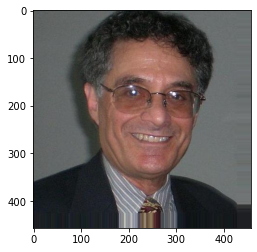

In [100]:
img = cv2.imread(path)
plt.imshow(img[...,::-1])

In [269]:

# 設個x,y list來存放等等讀取的data及label
x=[]
y=[]
img_size = 256
label = 0

# 兩個for迴圈從train資料夾中一個一個folder讀取影像
for i in new_wiki.path[7000:8500]:
  img_file = glob.glob('/Users/macy1/JupyterLab/project1/wiki_crop/'+i)
  
  label = new_wiki[new_wiki['path'] == i]
  label = int(label["gender"])
  




  for f in img_file:
      img = cv2.imread(f,1) # cv2讀影像，0:GRAYSCALE 1:COLOR 2:UNCHANGED
      img_resize = cv2.resize(img,(img_size,img_size))
      img_resize_reshape = (np.reshape(img_resize,(img_size,img_size,3))).astype(float) # 將image做reshape成待會模型input的樣子
      x.append(img_resize_reshape) # 存放至x list當中
      
      img_onehot = np.zeros(2,dtype=float) # :[0 0 0 0 0 0] →待會紀錄label (one hot型式)
      img_onehot[label] = 1
      y.append(img_onehot) # 將onehot完的label 存放至y list當中

x_data=np.array(x) # 將讀完的資料轉成array形式
y_data=np.array(y)# 將紀錄完的label轉成array形式

In [270]:
x_data.shape #(num, height, width, cannel)

(1500, 256, 256, 3)

In [271]:
y_data.shape

(1500, 2)

### 切割訓練及驗證資料

In [274]:
X_train, X_valid, y_train, y_valid = train_test_split(x_data,y_data,test_size=0.2, random_state=42)

In [275]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(1200, 256, 256, 3)
(1200, 2)
(300, 256, 256, 3)
(300, 2)


In [276]:
num_class = 2
learning_rate = 0.0005
loss = 'categorical_crossentropy'
metrics = 'accuracy'

In [142]:
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input

In [277]:
model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3))

In [278]:
x = GlobalAveragePooling2D()(model_InceptionV3.output)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
new_model_InceptionV3 = Model(inputs=model_InceptionV3.input, outputs=predictions)

In [279]:
new_model_InceptionV3.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 127, 127, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 127, 127, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 127, 127, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [280]:
model_InceptionV3.trainable = False

trainable_layer = 3
for layer in model_InceptionV3.layers[-trainable_layer:]:
    layer.trainable = True

for layer in new_model_InceptionV3.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000221568303A0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000221568B71F0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002215684F5B0> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000022155B00820> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002215684F340> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000221568B7B20> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000221568ED250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000221568EDD30> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000221568E0EB0> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000221568E7700> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000221568F5

In [281]:
optimizer = keras.optimizers.Adam(lr = learning_rate)
new_model_InceptionV3.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [282]:
batch_size = 40
num_steps = len(X_train) // batch_size 
num_epochs = 10
print(num_steps)

30


In [283]:
train_datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  fill_mode='wrap',
                  preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [284]:
train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)

valid_generator = test_datagen.flow(X_valid,y_valid,batch_size=batch_size)

In [285]:
history = new_model_InceptionV3.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator)

Epoch 1/10
30/30 [==============================] - 72s 2s/step - loss: 0.5848 - accuracy: 0.7261 - val_loss: 0.3552 - val_accuracy: 0.8700
Epoch 2/10
30/30 [==============================] - 62s 2s/step - loss: 0.3204 - accuracy: 0.8820 - val_loss: 0.3108 - val_accuracy: 0.8933
Epoch 3/10
30/30 [==============================] - 64s 2s/step - loss: 0.2511 - accuracy: 0.9016 - val_loss: 0.3151 - val_accuracy: 0.9000
Epoch 4/10
30/30 [==============================] - 66s 2s/step - loss: 0.2495 - accuracy: 0.9007 - val_loss: 0.3944 - val_accuracy: 0.8567
Epoch 5/10
30/30 [==============================] - 66s 2s/step - loss: 0.2464 - accuracy: 0.9041 - val_loss: 0.3227 - val_accuracy: 0.8833
Epoch 6/10
30/30 [==============================] - 66s 2s/step - loss: 0.2561 - accuracy: 0.8968 - val_loss: 0.2749 - val_accuracy: 0.8800
Epoch 7/10
30/30 [==============================] - 65s 2s/step - loss: 0.2623 - accuracy: 0.9053 - val_loss: 0.3158 - val_accuracy: 0.8867
Epoch 8/10
30/30 [==

In [286]:
new_model_InceptionV3.save('/Users/macy1/JupyterLab/project1/inceptionV3_best_model.h5')

In [287]:
test = load_model('/Users/macy1/JupyterLab/project1/inceptionV3_best_model.h5')

loss,acc = test.evaluate_generator(valid_generator, verbose=2)

8/8 - 11s - loss: 0.2923 - accuracy: 0.8967


In [293]:
f='/Users/macy1/JupyterLab/project1/111.jpg'
z=[]
img_size = 256

#img = cv2.imread(f,1) # cv2讀影像，0:GRAYSCALE 1:COLOR 2:UNCHANGED
# img_resize = cv2.resize(img,(img_size,img_size))
# img_resize_reshape = (np.reshape(img_resize,(img_size,img_size,3))).astype(np.float) # 將image做reshape成待會模型input的樣子
# x1.append(img_resize_reshape) # 存放至x list當中


img = cv2.imread(f,1) # cv2讀影像，0:GRAYSCALE 1:COLOR 2:UNCHANGED
img_resize = cv2.resize(img,(img_size,img_size))
img_resize_reshape = (np.reshape(img_resize,(img_size,img_size,3))).astype(float) # 將image做reshape成待會模型input的樣子
z.append(img_resize_reshape) # 存放至x list當中
data_z = np.array(z)

In [295]:
pre = test.predict(data_z)
print(pre)

[[2.1268452e-05 9.9997878e-01]]


In [289]:
test.predict(data_z)
loss,acc = test.evaluate_generator(valid_generator, verbose=2)

8/8 - 10s - loss: 0.2923 - accuracy: 0.8967
